In [ ]:
# how to customize: quick tutorial:
# the blurring im doing is a gausian blur, making the sigma and kernel bigger will make it blur harder
# so if you want to make tha lago work faster, do that. (it will be worse tho)

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import time
from IPython.display import clear_output

c:\Users\user\anaconda3\envs\MAIN_ENV\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\user\anaconda3\envs\MAIN_ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device that will be used on the whole ipynb
RUN_DEVICE = torch.device("cuda")

#                              convolution settings
#  ____________________________________|______________________________________
# |                                                                          |
# the conv kernel that will be applying the fast and innacurate "blooming", function: !!!ADD NAME LATER!!!
size = 3 # <- make sure odd number
sigma = 1
# chatgpt wrote this line idk what it is myself
kernel_weights = torch.tensor([[math.exp(-((i - size//2)**2 + (j - size//2)**2) / (2 * sigma**2)) for j in range(size)] for i in range(size)], dtype=torch.float32, device=RUN_DEVICE)
kernel = kernel_weights.repeat(1, 1, 1, 1)
padding = (kernel.shape[2] - 1) // 2

In [3]:
# load png / jpg / whatever image from path to tensor
# should be self explanatory
def image_to_tensor(image_path):
    image = Image.open(image_path).convert('RGB')

    tensor_image = transforms.ToTensor()(image)
    tensor_image = tensor_image.to(RUN_DEVICE)

    return tensor_image

In [4]:
# take in tensor (like what function above returns)
# and display it with plt
def show_tensor_image(tensor_image):
    pil_image = transforms.ToPILImage()(tensor_image)
    plt.imshow(pil_image, cmap='gray')
    plt.show()

In [5]:
# function's purpose is to add "raytracer" - like noise
# that means darker regions get more noise         -1   <---------->   0   <---------->   1
# noise_goofy controlls the amount of noise:     no noise        normal noise      everything is noise
def add_fake_noise(image_tensor, noise_goofy=0):
    # avarage rgb channels to get how dark each pixel is
    dropout_prob_mask = torch.sum(image_tensor, dim=0) / 3
    # generate a random number for each pixel (from 0 to 1)
    random_decision_mask = torch.rand(dropout_prob_mask.shape, device=RUN_DEVICE)
    # check for each pixel if the random number generated passes the "dropout threshhold"
    # so basically if it doesnt pass: pixel is false (aka 0)
    dropout_mask = dropout_prob_mask - noise_goofy > random_decision_mask
    
    # multiply the true / false value of each pixel (it decides if it should be blackened or not) by the real image
    return dropout_mask == False, image_tensor * dropout_mask

In [6]:
# this function is so smart your python interpreter might have trouble understanding it
def bloom(image_tensor, marked_for_denoising, unmarked_for_denoising, kernel=kernel, padding=padding):
    # explanation why goofy ahh channel split and not just conv over full image:
    # for some reason when i do it the normal way the image comes out black and white and this just works im not gonna fix it
    red_channel = image_tensor[0].unsqueeze(0)
    green_channel = image_tensor[1].unsqueeze(0)
    blue_channel = image_tensor[2].unsqueeze(0)
    
    # apply padding seperatly because i want to use "reflect" mode
    red_channel_padded = F.pad(red_channel, [padding] * 4, mode='reflect')
    green_channel_padded = F.pad(green_channel, [padding] * 4, mode='reflect')
    blue_channel_padded = F.pad(blue_channel, [padding] * 4, mode='reflect')
    
    # apply conv here
    red_conv = F.conv2d(red_channel_padded, kernel)
    green_conv = F.conv2d(green_channel_padded, kernel)
    blue_conv = F.conv2d(blue_channel_padded, kernel)
    
    # stack the channels back into a single image
    colored_result = torch.cat((red_conv, green_conv, blue_conv), dim=0)
    
    # this image is the new information that the function has generated
    black_fill = colored_result * marked_for_denoising
    
    # we want to normalize that because conv might return a bigger value than 1
    black_fill /= torch.max(black_fill)
    
    # original image is the image as if this function has never touched it
    # even reset previous of this function's edurations over it
    original_image = image_tensor * unmarked_for_denoising
    
    # place the progress of this function + all the functions before it on the original image
    return original_image + black_fill

In [7]:
def denoise(image_tensor, blooming_func, marked_for_denoising, unmarked_for_denoising, difference_tolerance_precent, movie=False, movie_fps=10):
    difference = difference_tolerance_precent + 1
    
    while difference > difference_tolerance_precent:
        movie_time_start = time.time()
        before_denoise = image_tensor
        image_tensor = blooming_func(image_tensor, marked_for_denoising, unmarked_for_denoising)
        difference = torch.sum(torch.abs(before_denoise - image_tensor)) / torch.prod(torch.tensor(image_tensor.shape)) * 100
        
        if movie:
            clear_output(wait=True)
            show_tensor_image(image_tensor)
            movie_time_end = time.time()
            
            # make sure that we wait the right amount of time before the next frame is drawn
            time.sleep(max(0, 1 / movie_fps - (movie_time_end - movie_time_start)))
    
    return image_tensor

original image:


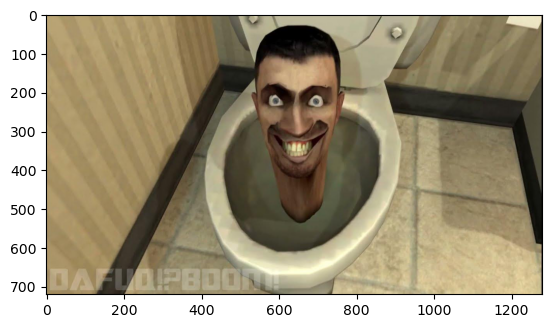

noisy image:


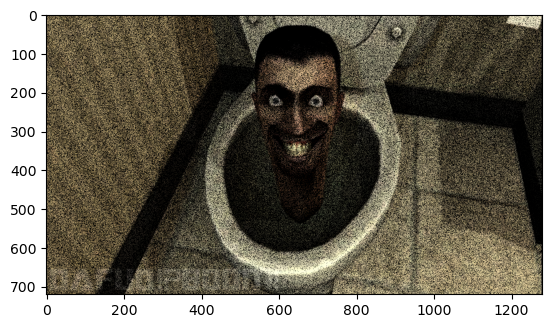

black pixels -> denoiser needs to guess:


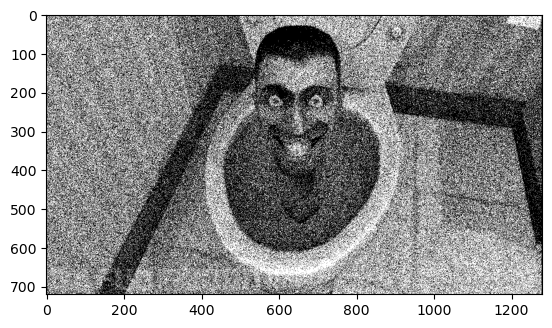

In [21]:
image = image_to_tensor(fr"path/to/image.png")

print("original image:")
show_tensor_image(image)

marked_for_denoising, image = add_fake_noise(image, noise_goofy=0.0)
marked_for_denoising = marked_for_denoising.unsqueeze(0).to(torch.float32)
# use this instead if you want to mark all pitch black pixels as noise
#marked_for_denoising = torch.all(image == 0, dim=0).unsqueeze(0).to(torch.float32)
unmarked_for_denoising = (marked_for_denoising == 0).to(torch.float32)

print("noisy image:")
show_tensor_image(image)

print("black pixels -> denoiser needs to guess:")
show_tensor_image(unmarked_for_denoising)

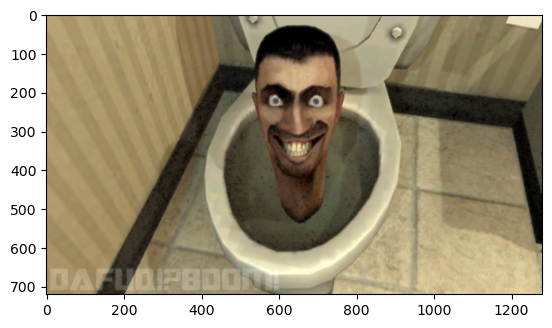

In [22]:
image = denoise(image, bloom, marked_for_denoising, unmarked_for_denoising, difference_tolerance_precent=0.05, movie=True, movie_fps=60)